In [1]:
# data exploration of grouting results for Rogun Powerhhouse (PH) and Transformer Hall (TH)
# work peformed during June 2018

In [2]:
# coding notes
#   no for loops used -> see #JK pattern 


In [3]:
# setup for python ecosystem
import json
from math import *
import pandas as pd
import numpy as np
from IPython.core.display import HTML, display
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import norm
from scipy.stats import lognorm
from scipy import stats

In [4]:
# setup for pixiedust data exploration
#!sudo pip install --upgrade pixiedust
#!sudo pip install --user --upgrade pixiedust
import pixiedust
from pixiedust.display import *

Pixiedust database opened successfully


In [5]:
# setup for plotly in 'offline' mode                            #ToDo JK: this should be cleaned up and documented
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
print (__version__) # requires version >= 1.9.0

# collect all plotly setups here
import plotly.offline as plotly
from plotly.graph_objs import *

2.2.1


In [6]:
# setup for qgis processing
import sys, os
from qgis.core import QgsApplication
from PyQt4.QtGui import QApplication
app = QApplication([], True)  #True -> window display enabled
QgsApplication.setPrefixPath("/usr", True)
QgsApplication.initQgis()
sys.path.append('/usr/share/qgis/python/plugins')  #export PYTHONPATH not needed in start script
from processing.core.Processing import Processing
Processing.initialize() 
import processing
#from processing.tools import *  #not needed currently

In [7]:
# setup for pandas
# set maximum number of rows to display from a pandas data frame
pd.set_option('display.max_rows', 5000)
# set maximum number of rows to display from a pandas data frame
pd.set_option('display.max_columns',100)

In [8]:
# alignment input data

#datafile = 'data/Rogun/2018.05.20.Grouting_Data.csv'
#datafile = 'data/Rogun/2018.05.20.Grouting_Data_fixed.csv'
datafile = 'data/Rogun/2018.06.12.Grouting_Data_fixed.csv'

# create alignment dataframes from alignment csv data
# Rogun data: x: easting, y: northing
# alignment is chosen at the central longitudinal axis of the PH/TH
# alignment elevation is taken at the machine floor and transformer hall levels

ph_alignment_df = pd.DataFrame.from_records(
data =[
("Begin", "TP", 0.0, 27793.38, 23279.76, 968.20),     #x,y,z midpoint PH upslope end wall
("End", "TP", 221.552, 27579.31, 23336.85, 968.20)],  #x,y,z midpoint PH downslope end wall
columns=["Point","Type","Station","Easting","Northing","Elevation"] )

th_alignment_df = pd.DataFrame.from_records(
data =[
("Begin", "TP", 0.0, 27760.50, 23223.29, 990.10),     #x,y,z midpoint TH upslope end wall
("End", "TP", 199.606, 27567.53, 23274.33, 990.10)],  #x,y,z midpoint TH downslope end wall
columns=["Point","Type","Station","Easting","Northing","Elevation"] )

# define horizontal offsets to cavern walls perpendicular from alignment (anchor/gouthole locations)
# left offset is negative value of right offset
ph_bh_offset = 10.4  #to right in direction of stationing
th_bh_offset = 9.4  #to right in direction of stationing

In [9]:
ph_alignment_df

,Point,Type,Station,Easting,Northing,Elevation
0,Begin,TP,0.000,27793.38,23279.76,968.2
1,End,TP,221.552,27579.31,23336.85,968.2


In [10]:
th_alignment_df

,Point,Type,Station,Easting,Northing,Elevation
0,Begin,TP,0.000,27760.50,23223.29,990.1
1,End,TP,199.606,27567.53,23274.33,990.1


In [11]:
# grouting results input data

# df = pd.read_csv(datafile, names=names)
#data_df = pd.read_csv(datafile, parse_dates=True, dayfirst=True)  #testing
data_df = pd.read_csv(datafile, dayfirst=True, encoding='latin-1')  #needed for pixiedust
#data_df = pd.read_csv(datafile, dayfirst=True, encoding='utf8')  #tried to fix garbled 'Hole' str, NG
#print(data_df.count())

# drop records (rows) without Date entry  #two records dropped
data_df = data_df.dropna(subset=['Date'])  #drop all rows that have any NaN values
#print(data_df.count())

# use international data format ('coerce’ sets invalid dates to NaT)
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%d/%m/%Y', errors='coerce')

# data fixes based on field observations of grout leakage into openings
data_df.drop(data_df[data_df['Nr'] == 637].index, inplace=True)
data_df.drop(data_df[data_df['Nr'] == 729].index, inplace=True)
data_df.drop(data_df[data_df['Nr'] == 1967].index, inplace=True)
#print(data_df.count())

#data_df
#data_df.head()

In [12]:
# function for calculating x,y,z at an arbitrary station along a straight alignment
#   make applicable to bent alignment                                                                #ToDo JK
def align_station(alignment, station):
    # alignment must be a pandas df with Easting, Northing and Elevation column data
    # start of alignment
    x_0 = alignment['Easting'][0]
    y_0 = alignment['Northing'][0]
    z_0 = alignment['Elevation'][0]
    # end of alignment
    x_1 = alignment['Easting'][len(alignment)-1]
    y_1 = alignment['Northing'][len(alignment)-1]
    z_1 = alignment['Elevation'][len(alignment)-1]
    align_horiz_len = sqrt((x_0 - x_1)**2 + (y_0 - y_1)**2)
    # coords of stationed point along alignment
    x_stat = x_0 + ((x_1 - x_0) * station/align_horiz_len)
    y_stat = y_0 + ((y_1 - y_0) * station/align_horiz_len)
    z_stat = z_0 + ((z_1 - z_0) * station/align_horiz_len)
    return(x_stat,y_stat,z_stat)                                                  #JK return normal vector ???

# testing
#print(align_station(ph_alignment_df, 221.552/2))  #ok
#print(align_station(ph_alignment_df, data_df["Chainage"]))  #ok
#print(align_station(ph_alignment_df, data_df["Chainage"])[0])  #ok
#print(np.array(align_station(ph_alignment_df, data_df["Chainage"]))[[0,1,2]])  #ok

#data_df.head()

In [13]:
# # function for calculating x,y at horizonal offset perpendicular from an alignment station
# #   does not require station_coords to be in df                                     #JK keep for reference!!!
# def align_offset(alignment, station, offset):
#     x_0 = alignment['Easting'][0]
#     y_0 = alignment['Northing'][0]
#     x_1 = alignment['Easting'][len(alignment)-1]
#     y_1 = alignment['Northing'][len(alignment)-1]
#     station_coords = align_station(alignment, station)
#     x_stat = station_coords[0]
#     y_stat = station_coords[1]
#     z_stat = station_coords[2]
#     print(x_stat,y_stat,z_stat)
#     vect = np.array([x_1-x_0, y_1-y_0])
#     print(vect)
#     horiz_len = sqrt((x_0 - x_1)**2 + (y_0 - y_1)**2)
#     normal_vect = np.array([vect[1], -vect[0]])
#     normal_unitvect = normal_vect / horiz_len
#     right_offset_coords = np.array([x_stat, y_stat]) + normal_unitvect*offset
#     left_offset_coords = np.array([x_stat, y_stat]) - normal_unitvect*offset
#     x_rt_offset = right_offset_coords[0] 
#     y_rt_offset = right_offset_coords[1] 
#     x_lt_offset = left_offset_coords[0] 
#     y_lt_offset = left_offset_coords[1] 
#     return(x_stat, y_stat, z_stat, x_rt_offset, y_rt_offset, x_lt_offset, y_lt_offset, normal_unitvect)

# # testing
# #print(align_offset_0(ph_alignment_df, 100, 10.4))  #ok
# #print(align_offset_0(ph_alignment_df, data_df["Chainage"], 10.4)[7])  #ok

In [14]:
# function for calculating x,y at horizonal offset perpendicular from an alignment station
#   does requires station_coords to be in df
#   make applicable to bent alignment                                                                #ToDo JK
def align_offset_df(alignment, x_stat, y_stat, z_stat, offset):
    # vector along alignment (assumes alignment to be sraight)
    x_0 = alignment['Easting'][0]
    y_0 = alignment['Northing'][0]
    x_1 = alignment['Easting'][len(alignment)-1]
    y_1 = alignment['Northing'][len(alignment)-1]
    vect = np.array([x_1-x_0, y_1-y_0])
    # unit normal vector perpendicular to alignment, to right in dir of alignment
    horiz_len = sqrt((x_0 - x_1)**2 + (y_0 - y_1)**2)
    normal_vect = np.array([vect[1], -vect[0]])
    normal_unitvect = normal_vect / horiz_len
    # coordinates at point offset pendicular to alignment
    x_offset = x_stat + normal_unitvect[0]*offset
    y_offset = y_stat + normal_unitvect[1]*offset
    return(x_stat, y_stat, z_stat, x_offset, y_offset, normal_unitvect)

# testing
#print(align_offset(ph_alignment_df, 27696.757, 23305.528, 968.2, 10.4))  #ok
#print(align_offset(ph_alignment_df, data_df['x_stat'],data_df['y_stat'],data_df['z_stat'], 10.4))  #ok

In [15]:
# function for calculating x,y,z at a borehole depth from a collar x,y,z and a borehole normal unit vector
#   assumes boreholes perpedicular to wall in horizontal plane
def borehole_coords_atdepth(offset, x_offset, y_offset, z_offset, norm_unitvect, inclin, depth):
    # determine bh unit vector
    num=len(x_offset)
    # direction of offset from alginment (right is pos, left is neg)
    dir = offset / abs(offset)
    norm_unitvect_x = np.linspace(norm_unitvect[0], norm_unitvect[0], num) *dir
    norm_unitvect_y = np.linspace(norm_unitvect[1], norm_unitvect[1], num) *dir    
    bh_norm_vect = norm_unitvect_x, norm_unitvect_y, np.tan(inclin/180.0 * pi)    
    bh_norm_vect_len = np.sqrt(norm_unitvect[0]**2 +norm_unitvect[1]**2 + np.tan(inclin/180.0 * pi)**2)
    bh_norm_unitvect = bh_norm_vect / bh_norm_vect_len
    # determine coordinates of borehole at given depth
    bh_collar = (x_offset, y_offset, z_offset)
    bh_coords_atdepth = np.array(bh_collar) + bh_norm_unitvect*depth
    return(bh_coords_atdepth)    

In [16]:
# consider data for PH and TH separately
# use 'align_station' to add station coordinates to all stationing in df

# PH
#data_ph = data_df.loc[(data_df['Opening'] == 'PH') & (data_df['Type'] == 'Dowel')]       #JK pattern df filter
data_ph = data_df.loc[(data_df['Opening'] == 'PH')]
print(len(data_ph))
#data_ph.head()

data_ph['x_stat'], data_ph['y_stat'], data_ph['z_stat'] = (                             #JK pattern df function
    np.array(align_station(ph_alignment_df, data_ph["Chainage"]))[[0,1,2]])

# TH
data_th = data_df.loc[(data_df['Opening'] == 'THC')]
print(len(data_th))
#data_th_dowels

data_th['x_stat'], data_th['y_stat'], data_th['z_stat'] = (
    np.array(align_station(th_alignment_df, data_th["Chainage"]))[[0,1,2]])

1174
1642


In [17]:
# # determine offset from alignment to boreholes according to 'Hole' designatin of borehole
# #                                                                      #documentation of encoding problem!!!
# data_ph['Offset']=np.nan
# data_th['Offset']=np.nan
# holes_ph_us ='AA|AB|AC|AD|AE|AF|AG|AH|AI|AJ|AK|AL'
# holes_ph_ds ='BA|BB|BC|BD|BE|BF|BG|BH|BI|BJ|BK|BL|BM'

# # upstream holes in PH (right from alignment)
# data_ph.loc[data_ph['Hole'].str.contains(holes_ph_us), ['Offset']] = ph_bh_offset
# # downstream holes in PH (left frm alignment)
# data_ph.loc[data_ph['Hole'].str.contains(holes_ph_ds), ['Offset']] = -ph_bh_offset

# #data_ph[data_ph['Hole'].str.contains(holes_ph_us)][['Offset','Hole']]

# print(len(data_ph[data_ph['Hole'].str.contains(holes_ph_us)]))  #582
# print(len(data_ph[data_ph['Hole'].str.contains(holes_ph_ds)]))  #499  => 582 + 499 = 1081
# print(len(data_ph)) #1177
# # Holes w/o value display a garbled string, seemingly due to encoding.
# # This only affect holes on upstream wall.
# # Workaround: set default value of offest to 'ph_bh_offset' 
# # and reset valuoe to -ph_bh_offset for downstream holes.

# data_ph.loc[(data_ph['Offset'] != 10.4) & (data_ph['Offset'] != -10.4)]  
# #  works with 10.4, does not wok with 'ph_bh_offset' ???

In [18]:
# add to df offsets from alignment to boreholes according to 'Hole' designation of borehole

data_ph['Offset'] = ph_bh_offset
data_th['Offset'] = -th_bh_offset

# Powerhouse
holes_ph_us = 'AA|AB|AC|AD|AE|AF|AG|AH|AI|AJ|AK|AL'
holes_ph_ds = 'BA|BB|BC|BD|BE|BF|BG|BH|BI|BJ|BK|BL|BM'

# upstream holes in PH (right from alignment)
# workaround because of garbled data: 'Offset' for upstream holes already set at initiation 
#data_ph.loc[data_ph['Hole'].str.contains(holes_ph_us), ['Offset']] = ph_bh_offset

# downstream holes in PH (left frm alignment)
data_ph.loc[data_ph['Hole'].str.contains(holes_ph_ds), ['Offset']] = -ph_bh_offset      #JK pattern df replace

#data_ph[data_ph['Hole'].str.contains(holes_ph_us)][['Offset','Hole']]  #testing
#data_ph.loc[(data_ph['Offset'] != 10.4) & (data_ph['Offset'] != -10.4)]  #0 records

# Transformet Hall
holes_th_us = 'UA|UB|UC|UD|UE|UF|UG|UH|UI|UJ|UK|UL|UM|UN|UO|UP|UQ|UR'
holes_th_ds = 'DA|DB|DC|DD|DE|DF|DG|DH|DI|DJ|DK|DL|DM'
# data fixes due to encoding issues with spreadsheet data causing grabled data
data_th.loc[(data_th['Nr'] == 1385), ['Hole']] = 'UE-5'
data_th.loc[(data_th['Nr'] == 2623), ['Hole']] = 'UE-5'

# upstream holes in TH (right from alignment)
data_th.loc[data_th['Hole'].str.contains(holes_th_us), ['Offset']] = th_bh_offset

# downstream holes in TH (left frm alignment)
# workaround because of garbled data: 'Offset' for upstream holes already set at initiation 
#data_th.loc[data_th['Hole'].str.contains(holes_th_ds), ['Offset']] = -th_bh_offset

#data_ph[data_ph['Hole'].str.contains(holes_ph_us)][['Offset','Hole']]  #testing
#data_th.loc[(data_th['Offset'] != 9.4) & (data_th['Offset'] != -9.4)]  #0 records

# check fixed records
#print(data_th[(data_df['Nr'] == 1385)][['Nr','Hole','Offset']])  #UE-5, 9.4, ok
#print(data_th[(data_df['Nr'] == 2623)][['Nr','Hole','Offset']])  #UE-5, 9.4, ok

In [19]:
# use 'align_offset_df' to add coords for borehole collars to df

data_ph['x_offset'], data_ph['y_offset'], data_ph['z_offset'] = (
    np.array(align_offset_df(ph_alignment_df, 
                             data_ph['x_stat'],data_ph['y_stat'],data_ph['z_stat'],data_ph['Offset']))[[3,4,2]] )

data_th['x_offset'], data_th['y_offset'], data_th['z_offset'] = (
    np.array(align_offset_df(th_alignment_df, 
                             data_th['x_stat'],data_th['y_stat'],data_th['z_stat'],data_th['Offset']))[[3,4,2]] )

#data_ph.head()
#data_ph
#data_th

In [20]:
# unit vectors along PH and TH alignments
norm_unitvect_ph = (
    align_offset_df(ph_alignment_df,data_ph['x_stat'],data_ph['y_stat'],data_ph['z_stat'],ph_bh_offset))[5] 
print(norm_unitvect_ph)

norm_unitvect_th = (
    align_offset_df(th_alignment_df,data_th['x_stat'],data_th['y_stat'],data_th['z_stat'],th_bh_offset))[5] 
print(norm_unitvect_th)

[0.25768232 0.9662297 ]
[0.25570391 0.96675515]


In [21]:
# use 'borehole_coords_atdepth' to add coords for grouting stage max. depth to df

data_ph['x_stage_max'], data_ph['y_stage_max'], data_ph['z_stage_max'] = (
    np.array(borehole_coords_atdepth(data_ph['Offset'], 
                                     data_ph['x_offset'], data_ph['y_offset'], data_ph['z_offset'],
                                     np.array(norm_unitvect_ph), np.array(data_ph['Inclination']), 
                                     np.array(data_ph['Depth_max'])))[[0,1,2]] )

data_th['x_stage_max'], data_th['y_stage_max'], data_th['z_stage_max'] = (
    np.array(borehole_coords_atdepth(data_th['Offset'], 
                                     data_th['x_offset'], data_th['y_offset'], data_th['z_offset'],
                                     np.array(norm_unitvect_th), np.array(data_th['Inclination']), 
                                     np.array(data_th['Depth_max'])))[[0,1,2]] )

#data_ph
data_th

,Nr,Record,Opening,Location,Type,Hole,Chainage,Elevation,Inclination,Diameter,Date,Stage,Depth_max,Depth_min,Grout,Cement,x_stat,y_stat,z_stat,Offset,x_offset,y_offset,z_offset,x_stage_max,y_stage_max,z_stage_max
77,78,1,THC,US,Tendon,TUH-21,146.0,983.7,-10.0,110.0,2016-05-11,1,30,20,245.0,264.600,27619.353749,23260.622770,990.1,9.4,27621.757365,23269.710269,990.1,27629.311941,23298.272307,984.890555
78,79,2,THC,US,Tendon,TUJ-21,146.0,988.7,-10.0,110.0,2016-05-24,1,30,20,223.0,240.840,27619.353749,23260.622770,990.1,9.4,27621.757365,23269.710269,990.1,27629.311941,23298.272307,984.890555
79,80,3,THC,US,Tendon,TUJ-23,147.8,988.7,-10.0,110.0,2016-05-30,1,30,20,245.0,264.600,27617.613589,23261.083037,990.1,9.4,27620.017206,23270.170536,990.1,27627.571782,23298.732575,984.890555
80,81,4,THC,US,Tendon,TUH-23,151.0,983.7,-10.0,110.0,2016-05-22,1,30,20,720.0,777.600,27614.519973,23261.901290,990.1,9.4,27616.923590,23270.988788,990.1,27624.478165,23299.550827,984.890555
81,82,5,THC,US,Tendon,TUH-29,166.4,983.7,-10.0,110.0,2016-05-18,1,30,20,220.0,237.600,27599.631944,23265.839130,990.1,9.4,27602.035560,23274.926628,990.1,27609.590136,23303.488667,984.890555
82,83,6,THC,US,Tendon,TUF-25,155.3,978.7,-10.0,110.0,2016-08-04,1,30,20,220.0,237.600,27610.362926,23263.000817,990.1,9.4,27612.766543,23272.088315,990.1,27620.321118,23300.650354,984.890555
83,84,7,THC,US,Tendon,TUF-24,152.8,978.7,-10.0,110.0,2016-04-20,1,30,20,600.0,648.000,27612.779814,23262.361557,990.1,9.4,27615.183430,23271.449055,990.1,27622.738006,23300.011094,984.890555
84,85,8,THC,US,Tendon,TUF-27,160.3,978.7,-10.0,110.0,2016-04-10,1,30,20,154.0,166.320,27605.529150,23264.279336,990.1,9.4,27607.932767,23273.366834,990.1,27615.487342,23301.928873,984.890555
85,86,9,THC,US,Tendon,TUF-19,141.0,978.7,-10.0,110.0,2016-06-05,1,30,20,150.0,162.000,27624.187524,23259.344251,990.1,9.4,27626.591141,23268.431749,990.1,27634.145717,23296.993788,984.890555
86,87,10,THC,US,Tendon,TUF-23,147.8,978.7,-10.0,110.0,2016-04-14,1,30,20,160.0,172.800,27617.613589,23261.083037,990.1,9.4,27620.017206,23270.170536,990.1,27627.571782,23298.732575,984.890555


In [22]:
# plotly default colors
#    '#1f77b4',  // muted blue
#    '#ff7f0e',  // safety orange
#    '#2ca02c',  // cooked asparagus green
#    '#d62728',  // brick red
#    '#9467bd',  // muted purple
#    '#8c564b',  // chestnut brown
#    '#e377c2',  // raspberry yogurt pink
#    '#7f7f7f',  // middle gray
#    '#bcbd22',  // curry yellow-green
#    '#17becf'   // blue-teal

# plotly color picker
# https://plot.ly/ipython-notebooks/color-scales/#qualitative
#!sudo pip install colorlover
import colorlover as cl
from IPython.display import HTML
ryb = cl.scales['10']['div']['RdYlBu']; ryb

['rgb(165,0,38)',
 'rgb(215,48,39)',
 'rgb(244,109,67)',
 'rgb(253,174,97)',
 'rgb(254,224,144)',
 'rgb(224,243,248)',
 'rgb(171,217,233)',
 'rgb(116,173,209)',
 'rgb(69,117,180)',
 'rgb(49,54,149)']

In [23]:
# 2d check plot of alignment and offsets

ph_alignment_plot = go.Scatter(
    x=ph_alignment_df['Easting'].tolist(),
    y=ph_alignment_df['Northing'].tolist(),
    line=dict(width=3,
              color='#e377c2'),
    name ="ph_alignment"
)

th_alignment_plot = go.Scatter(
    x=th_alignment_df['Easting'].tolist(),
    y=th_alignment_df['Northing'].tolist(),
    line=dict(width=3,
              color='#e377c2'),
    name ="th_alignment"
)

# check_plot = go.Scatter(
#     x=[data_ph['x_stat'][818], data_ph['x_offset'][818]],
#     y=[data_ph['y_stat'][818], data_ph['y_offset'][818]],
#     line=dict(width=3,
#               color='rgb(0, 0, 0)'),
#     name ="check"
# )

ph_station_plot = go.Scatter(
    x=data_ph['x_stat'].tolist(),
    y=data_ph['y_stat'].tolist(),
    mode = "markers",
    hoverinfo = 'none',
    marker = dict(
        size = 5,
        color = '#2ca02c',
    ),
    name ="ph_stationing"
)

th_station_plot = go.Scatter(
    x=data_th['x_stat'].tolist(),
    y=data_th['y_stat'].tolist(),
    mode = "markers",
    hoverinfo = 'none',
    marker = dict(
        size = 5,
        color = '#2ca02c',
    ),
    name ="th_stationing"
)

ph_offset_plot = go.Scatter(
    x=data_ph['x_offset'].tolist(),
    y=data_ph['y_offset'].tolist(),
    mode = "markers",
    hoverinfo = 'none',
    marker = dict(
        size = 5,
        color = '#d62728',
    ),
    name ="collars"
)

th_offset_plot = go.Scatter(
    x=data_th['x_offset'].tolist(),
    y=data_th['y_offset'].tolist(),
    mode = "markers",
    hoverinfo = 'none',
    marker = dict(
        size = 5,
        color = '#d62728',
    ),
    name ="collars"
)

ph_stage_plot = go.Scatter(
    x=data_ph['x_stage_max'].tolist(),
    y=data_ph['y_stage_max'].tolist(),
    mode = "markers",
    hoverinfo = 'none',
    marker = dict(
        size = 5,
        color = '#17becf',
    ),
    name ="stages"    
)

th_stage_plot = go.Scatter(
    x=data_th['x_stage_max'].tolist(),
    y=data_th['y_stage_max'].tolist(),
    mode = "markers",
    hoverinfo = 'none',
    marker = dict(
        size = 5,
        color = '#9467bd',
    ),
    name ="stages"    
)

data = [ph_alignment_plot, th_alignment_plot, ph_station_plot, th_station_plot, 
        ph_offset_plot, th_offset_plot, ph_stage_plot, th_stage_plot]

layout = go.Layout(
    width=1000,
    height=1000,    
    xaxis=dict(
    range = [27500,27800]
    ),
    yaxis=dict(
        range = [23200,23500]
    ),
)


fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig, show_link=False)


In [24]:
# 3d visualization with plotly

ph_alignment = go.Scatter3d(
    x=ph_alignment_df['Easting'].tolist(),
    y=ph_alignment_df['Northing'].tolist(),
    z=ph_alignment_df['Elevation'].tolist(),
    mode='lines',
    line=dict(width=3,
              color='#17becf'),
    name ="ph_alignment",   
)

th_alignment = go.Scatter3d(
    x=th_alignment_df['Easting'].tolist(),
    y=th_alignment_df['Northing'].tolist(),
    z=th_alignment_df['Elevation'].tolist(),
    mode='lines',
    line=dict(width=3,
              color='#9467bd'),
    name ="ph_alignment",   
)
    
ph_stages = go.Scatter3d(
    x=(data_ph['x_stage_max']),
    y=(data_ph['y_stage_max']),
    z=(data_ph['z_stage_max']),
    mode='markers',
    marker=dict(
        size=(data_ph['Cement']/150),
        color = '#17becf',        
        opacity=1.0
    )
)

th_stages = go.Scatter3d(
    x=(data_th['x_stage_max']),
    y=(data_th['y_stage_max']),
    z=(data_th['z_stage_max']),
    mode='markers',
    marker=dict(
        size=(data_th['Cement']/150),
        color = '#9467bd',
        opacity=1.0
    )
)

data = [ph_alignment, th_alignment, ph_stages, th_stages]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    
    scene=Scene(
        xaxis=dict(
            range = [27500,27800]
        ),
        yaxis=dict(
            range = [23200,23500]
        ),
        zaxis=dict(
            range = [800,1100]
        )
    )
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig, filename='simple-3d-scatter')


In [25]:
# setup for pixiedust display()
# moving this setup to beginning of notebook causes stange behvaiour, e.g. print no longer works
# https://stackoverflow.com/questions/2276200/changing-default-encoding-of-python
#import sys
#reload(sys)
#sys.setdefaultencoding('utf8')

# it is much better to set encoding of df, adding parameter encoding='latin-1' in read_csv


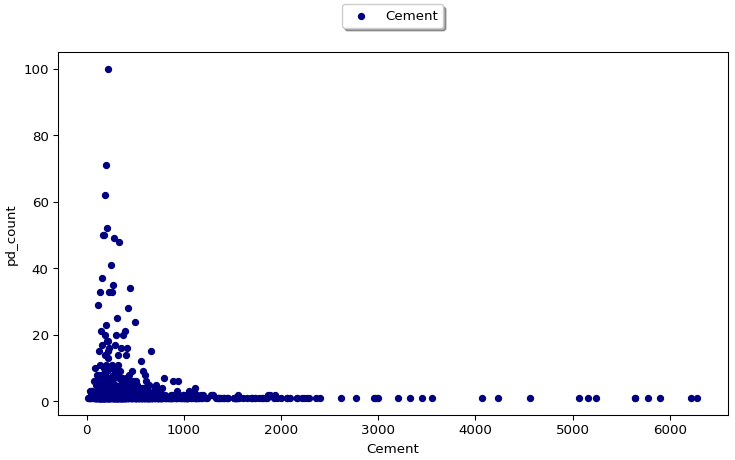

In [26]:
# data exploration with pixidust
display(data_df)  #pixiedustinspections = pixiedust.sampleData display

In [27]:
len(data_df)

2816

In [28]:
# evaluate using grass nviz for 3d visualization

#processing.alglist()